In [1]:
import pandas as pd
import difflib

df = pd.read_csv('outputs2/all.csv')
# df['Label'] = df['Label'].str.lower()
df

,fact_checked_segment,comment_by_fact-checker,split,label,debunk
0,“Recent computer forecasts suggest that if gre...,The “recent computer forecasts” referenced he...,test,vagueness,Antarctica's ice sheets could break up rapidly...
1,“So it’s been a surprise to climate scientists...,The claim that this is “a surprise to climate ...,train,no fallacy,TITLE: El Niño is not the only factor affectin...
2,"“In the U.S. about 9,000 people die from heat ...",This suggests that the dependency is not linea...,train,no fallacy,Cold weather is indeed a significant health ri...
3,“climate economists see a positive externality...,This is cherry-picking at its worst. You can a...,train,cherry picking,TITLE: Climate Change Can Have Positive Extern...
4,The Rio Grande is a classic “feast or famine” ...,Weird wording. It’s just an arid river with hi...,train,vagueness,TITLE: The Rio Grande is a Feast or Famine Riv...
...,...,...,...,...,...
678,in 1995 one scientist at the IPCC – Jonathan O...,I challenge the author to find a source for th...,train,false authority,TITLE: The Medieval Warm Period was a real eve...
679,“in a letter to The Times from Lord Krebs and ...,This is a misrepresentation of the Lords’ lett...,train,strawman,TITLE: Lord Krebs and colleagues urge The Time...
680,"“Some experts, such as UN climate scientist Dr...",I don’t believe that Dr. Goklany was ever empl...,dev,false authority,TITLE: The Benefits and Drawbacks of Rising CO...
681,“The ‘ancient carbon’ of Alaska’s tundras is b...,This is an interesting headline and quote. The...,train,evading the burden of proof,TITLE: Ancient Carbon in Alaska's Tundras is B...


In [2]:
def expand_response(response):
    d = {}
    try:
        answer = response.split('\n')
        for component in answer:
            title, content = component.split(':')
            d[title] = content.strip()
    except:
        return response
    return d

def find_closest_label(statement):
    """
    Identify the closest label to the fallacy in the statement
    """
    statement = statement.lower()

    labels = {'ad hominem': ['ad hominem'],
                'ambiguity': ['ambiguity', 'vagueness'],
                'anecdote': ['anecdote'],
                'blowfish': ['blowfish'],
                'bulk fake experts': ['bulk fake experts'],
                'cherry picking': ['cherry picking', 'cherry-picking'],
                'contradictory': ['contradictory'],
                'conspiracy theory': ['conspiracy theory'],
                'fake debate': ['fake debate'],
                'fake experts': ['fake experts', 'irrelevant authority', 'appeal to authority'],
                'false analogy': ['false analogy'],
                'false choice': ['false choice'],
                'false equivalence': ['false equivalence'],
                'immune to evidence': ['immune to evidence'],
                'impossible expectations': ['impossible expectations'] ,
                'logical fallacies': ['logical fallacies', 'logical fallacy'],
                'magnified minority': ['magnified minority'],
                'misrepresentation': ['misrepresentation'],
                'moving goalposts': ['moving goalposts'],
                'nefarious intent': ['nefarious intent'],
                'overriding suspicion': ['overriding suspicion'],
                'oversimplification': ['oversimplification', 'causal oversimplification', 'post hoc', 'post-hoc', 'false cause'],
                'persecuted victim': ['persecuted victim'],
                'quote mining': ['quote mining'],
                're-interpreting randomness': ['re-interpreting randomness'],
                'red herring': ['red herring'],
                'single cause': ['single cause'],
                'slippery slope': ['slippery slope'],
                'slothful induction': ['slothful induction'],
                'something must be wrong': ['something must be wrong'],
                'strawman': ['straw man', 'strawman'],
                'no fallacy': ['no fallacy', 'none', 'misunderstanding', 'not a fallacy'],
                'evading burden of proof':['evading burden of proof'],
                'faulty generalization': ['hasty generalization', 'faulty generalization']}

    closest_label = None
    highest_score = 0


    for label, similar_words in labels.items():
        for word in similar_words:
            if word in statement:
                boost = 0.2
            else:
                boost = 0
            score = difflib.SequenceMatcher(None, word, statement).ratio() + boost
            if score > highest_score:
                closest_label = label
                highest_score = score

    return closest_label


def get_closest_label(response):
    for k,v in response.items():
        if k.lower() == 'fallacy':
            sentence = v
            return find_closest_label(sentence)


def get_dict(response):
    reply = dict()
    if response.startswith('TITLE'):
        chunks = response.split('\n')
        for chunk in chunks:
            try:
                k,v = chunk.split(':')
                reply[k] = v
            except ValueError:
                # if the chunk is empty, continue to the next one.
                continue
    
        return True, reply
    
    else:

        return False, response


In [3]:
df['debunk'] = df['debunk'].apply(expand_response)
df['dict'] = df['debunk'].apply(lambda x: isinstance(x, dict))

flicc_map = {'causal oversimplification':'oversimplification',
            'vagueness':'ambiguity',
            'false authority':'fake experts',
            'hasty generalization': 'faulty generalization',
            'evading the burden of proof': 'evading burden of proof'}


# ['no fallacy', 'cherry picking', 'false equivalence',
#        'oversimplification', 'ambiguity', 'false choice', 'strawman',
#        'bulk fake experts', 'slippery slope', 'false analogy', 'fake experts',
#        'something must be wrong', 'logical fallacies',
#        'impossible expectations', 'slothful induction', 'misrepresentation',
#        'faulty generalization', 'evading burden of proof',
#        'immune to evidence', 'red herring', 'moving goalposts', 'quote mining',
#        'conspiracy theory', 'blowfish', 'magnified minority',
#        'overriding suspicion', 're-interpreting randomness']



# Index(['no fallacy', 'cherry picking', 'ambiguity', 'red herring',
#        'causal oversimplification', 'fake experts',
#        'evading the burden of proof', 'strawman', 'false analogy',
#        'faulty generalization'],



df['label'] = df['label'].apply(lambda x: flicc_map.get(x) if x in flicc_map else x)

In [4]:
preds = []
incorrect_structure = []
for i in df.index:
    try:
        # if response is a correct formatted dict, find the closest label
        preds.append(get_closest_label(df.loc[i, 'debunk']))
    except AttributeError: 
        # AttributeError means the response is not a correct formatted dict
        update, response = get_dict(df.loc[i, 'debunk'])
        if update:
            preds.append(get_closest_label(response))
            df.loc[i, 'dict'] = True
        else:
            incorrect_structure.append(i)
            preds.append(False)
        
    except Exception as e:
        print(e)
        incorrect_structure.append(i)
        preds.append(False)

df['predictions'] = preds
df['predictions'] = df['predictions'].replace('nofallacy', 'no fallacy')

# assumes None == no fallacy, False == no fallacy
df['predictions'] = df['predictions'].fillna('no fallacy')
df['predictions'] = df['predictions'].replace(False, 'no fallacy')

# map false cause and post hoc to causal oversimplification:
df['label'] = df['label'].replace('false cause', 'oversimplification')
df['label'] = df['label'].replace('post hoc', 'oversimplification')
df['predictions'] = df['predictions'].replace('false cause', 'oversimplification')
df['predictions'] = df['predictions'].replace('post hoc', 'oversimplification')

# check correct results
df['corrects'] = df['label'] == df['predictions']

df


,fact_checked_segment,comment_by_fact-checker,split,label,debunk,dict,predictions,corrects
0,“Recent computer forecasts suggest that if gre...,The “recent computer forecasts” referenced he...,test,ambiguity,Antarctica's ice sheets could break up rapidly...,False,no fallacy,False
1,“So it’s been a surprise to climate scientists...,The claim that this is “a surprise to climate ...,train,no fallacy,{'TITLE': 'El Niño is not the only factor affe...,True,oversimplification,False
2,"“In the U.S. about 9,000 people die from heat ...",This suggests that the dependency is not linea...,train,no fallacy,Cold weather is indeed a significant health ri...,False,no fallacy,True
3,“climate economists see a positive externality...,This is cherry-picking at its worst. You can a...,train,cherry picking,TITLE: Climate Change Can Have Positive Extern...,True,something must be wrong,False
4,The Rio Grande is a classic “feast or famine” ...,Weird wording. It’s just an arid river with hi...,train,ambiguity,{'TITLE': 'The Rio Grande is a Feast or Famine...,True,no fallacy,False
...,...,...,...,...,...,...,...,...
678,in 1995 one scientist at the IPCC – Jonathan O...,I challenge the author to find a source for th...,train,fake experts,{'TITLE': 'The Medieval Warm Period was a real...,True,quote mining,False
679,“in a letter to The Times from Lord Krebs and ...,This is a misrepresentation of the Lords’ lett...,train,strawman,{'TITLE': 'Lord Krebs and colleagues urge The ...,True,no fallacy,False
680,"“Some experts, such as UN climate scientist Dr...",I don’t believe that Dr. Goklany was ever empl...,dev,fake experts,{'TITLE': 'The Benefits and Drawbacks of Risin...,True,cherry picking,False
681,“The ‘ancient carbon’ of Alaska’s tundras is b...,This is an interesting headline and quote. The...,train,evading burden of proof,{'TITLE': 'Ancient Carbon in Alaska's Tundras ...,True,no fallacy,False


In [5]:
# Number of correct hamburger-format responses
df['dict'].value_counts()

True     560
False    123
Name: dict, dtype: int64

In [6]:
# Number of identified labels 
df[(df['dict'] == True) & (~df['predictions'].isna())].value_counts('predictions')

predictions
no fallacy                    216
cherry picking                113
false equivalence              60
oversimplification             54
ambiguity                      13
false choice                   12
strawman                       11
bulk fake experts              11
slippery slope                  7
false analogy                   6
fake experts                    6
something must be wrong         6
logical fallacies               6
impossible expectations         6
slothful induction              5
misrepresentation               4
faulty generalization           4
evading burden of proof         4
immune to evidence              3
red herring                     3
moving goalposts                2
quote mining                    2
conspiracy theory               2
blowfish                        1
magnified minority              1
overriding suspicion            1
re-interpreting randomness      1
dtype: int64

In [7]:
# Number of correctly identified labels
df[(df['dict'] == True)].value_counts('corrects')

corrects
False    458
True     102
dtype: int64

In [8]:
for i in df[(df['dict'] == True) & (df['corrects']== False)]['debunk'].index:
    if df.loc[i, 'predictions'] == 'oversimplification':
        try:
            print(df.loc[i, 'label'], '-->', df.loc[i, 'predictions'], '-->', df.loc[i, 'debunk']['FALLACY'])
        except:
            continue

no fallacy --> oversimplification --> This statement is an oversimplification, as it implies that El Niño is the sole cause of the recent warm temperatures. In reality, while El Niño can have a significant impact on global temperatures, it is just one of many factors that contribute to climate variability. Focusing solely on El Niño ignores the role of other factors, such as human-caused greenhouse gas emissions, in driving long-term warming trends.
no fallacy --> oversimplification --> This myth is an oversimplification and a slippery slope fallacy. While it is true that the Earth's climate has gone through natural cycles in the past, the current warming trend is happening at an unprecedented rate and is caused by human activities. Ignoring this fact and assuming that the current warming trend is just a natural fluctuation can lead to inaction and further exacerbation of the problem.
no fallacy --> oversimplification --> This myth is an example of a false cause fallacy, which assumes 

In [9]:
df[df['dict'] == False]

,fact_checked_segment,comment_by_fact-checker,split,label,debunk,dict,predictions,corrects
0,“Recent computer forecasts suggest that if gre...,The “recent computer forecasts” referenced he...,test,ambiguity,Antarctica's ice sheets could break up rapidly...,False,no fallacy,False
2,"“In the U.S. about 9,000 people die from heat ...",This suggests that the dependency is not linea...,train,no fallacy,Cold weather is indeed a significant health ri...,False,no fallacy,True
7,“Recent computer forecasts suggest that if gre...,This reflects recent research—an important poi...,train,ambiguity,Antarctica's ice sheets could break up rapidly...,False,no fallacy,False
8,“cold kills many more people than heat.”,"Lomborg seems unaware of, or more likely is ig...",train,cherry picking,"FACT1: Both cold and heat can be dangerous, bu...",False,no fallacy,False
10,“It’s far too early to tell if what we are see...,Certainly the loss of sea ice is largely a res...,train,faulty generalization,FACT1: Climate change is causing a shift towar...,False,no fallacy,False
...,...,...,...,...,...,...,...,...
648,“Policy makers who want to help the residents ...,This is a classic technique in Lomborg’s artic...,train,red herring,FACT1: The Marshall Islands are a low-lying is...,False,no fallacy,False
655,“But the differences between NOAA and NASA are...,"Daniel Swain, Researcher, UCLA, and Research F...",dev,no fallacy,NOAA and NASA have slightly different temperat...,False,no fallacy,True
657,“Any reasonable person can recognize both posi...,Lomborg seems to imply here that the assessmen...,dev,strawman,FACT1: Political policies are complex and can ...,False,no fallacy,False
664,"In 2004, two NOAA scientists, Richard Feely an...",This statement just flies in both the face of ...,train,no fallacy,Ocean acidification is not a significant probl...,False,no fallacy,True


In [10]:
for i in df[df['dict'] == False].index:
    print(df.loc[i, 'debunk'])

Antarctica's ice sheets could break up rapidly, causing the ocean to rise six feet or more by the end of this century if greenhouse gas emissions continue at a high level. However, the computer forecasts that predict this outcome are considered crude by the researchers who created them. There are still significant uncertainties about the trajectory of future climate around Antarctica. The researchers warn that the forecasts could be decades too fast or too slow.
Cold weather is indeed a significant health risk, and it is true that more people die from cold-related causes than from heat-related causes in the United States. However, the statement is misleading because it implies that cold weather is not affected by climate change. In reality, climate change is causing more frequent and severe extreme weather events, including cold snaps, which can have serious health consequences. Additionally, the statement ignores the fact that heat waves are becoming more frequent and intense due to c

In [11]:
df[df['dict'] == False]

,fact_checked_segment,comment_by_fact-checker,split,label,debunk,dict,predictions,corrects
0,“Recent computer forecasts suggest that if gre...,The “recent computer forecasts” referenced he...,test,ambiguity,Antarctica's ice sheets could break up rapidly...,False,no fallacy,False
2,"“In the U.S. about 9,000 people die from heat ...",This suggests that the dependency is not linea...,train,no fallacy,Cold weather is indeed a significant health ri...,False,no fallacy,True
7,“Recent computer forecasts suggest that if gre...,This reflects recent research—an important poi...,train,ambiguity,Antarctica's ice sheets could break up rapidly...,False,no fallacy,False
8,“cold kills many more people than heat.”,"Lomborg seems unaware of, or more likely is ig...",train,cherry picking,"FACT1: Both cold and heat can be dangerous, bu...",False,no fallacy,False
10,“It’s far too early to tell if what we are see...,Certainly the loss of sea ice is largely a res...,train,faulty generalization,FACT1: Climate change is causing a shift towar...,False,no fallacy,False
...,...,...,...,...,...,...,...,...
648,“Policy makers who want to help the residents ...,This is a classic technique in Lomborg’s artic...,train,red herring,FACT1: The Marshall Islands are a low-lying is...,False,no fallacy,False
655,“But the differences between NOAA and NASA are...,"Daniel Swain, Researcher, UCLA, and Research F...",dev,no fallacy,NOAA and NASA have slightly different temperat...,False,no fallacy,True
657,“Any reasonable person can recognize both posi...,Lomborg seems to imply here that the assessmen...,dev,strawman,FACT1: Political policies are complex and can ...,False,no fallacy,False
664,"In 2004, two NOAA scientists, Richard Feely an...",This statement just flies in both the face of ...,train,no fallacy,Ocean acidification is not a significant probl...,False,no fallacy,True


In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# le.fit(['ambiguity' , 'cherry picking' , 'evading burden of proof' , 'fake experts' , 'false analogy' , 'no fallacy' , 'oversimplification', 'red herring'])
le.fit(['no fallacy', 'cherry picking', 'false equivalence',
       'oversimplification', 'ambiguity', 'false choice', 'strawman',
       'bulk fake experts', 'slippery slope', 'false analogy', 'fake experts',
       'something must be wrong', 'logical fallacies',
       'impossible expectations', 'slothful induction', 'misrepresentation',
       'faulty generalization', 'evading burden of proof',
       'immune to evidence', 'red herring', 'moving goalposts', 'quote mining',
       'conspiracy theory', 'blowfish', 'magnified minority',
       'overriding suspicion', 're-interpreting randomness'])

# labels for all datapoint
y_true_all = le.transform(df['label'].to_numpy())
y_pred_all = le.transform(df['predictions'].to_numpy())

# labels for only correct format
y_true_ham = le.transform(df[(df['dict'] == True)]['label'].to_numpy())
y_pred_ham = le.transform(df[(df['dict'] == True)]['predictions'].to_numpy())

                            precision    recall  f1-score   support

                 ambiguity       0.23      0.04      0.07        74
                  blowfish       0.00      0.00      0.00         0
         bulk fake experts       0.00      0.00      0.00         0
            cherry picking       0.12      0.13      0.13       105
         conspiracy theory       0.00      0.00      0.00         0
   evading burden of proof       0.00      0.00      0.00        48
              fake experts       0.17      0.02      0.04        50
             false analogy       0.00      0.00      0.00        27
              false choice       0.00      0.00      0.00         0
         false equivalence       0.00      0.00      0.00         0
     faulty generalization       0.00      0.00      0.00         8
        immune to evidence       0.00      0.00      0.00         0
   impossible expectations       0.00      0.00      0.00         0
         logical fallacies       0.00      0.00

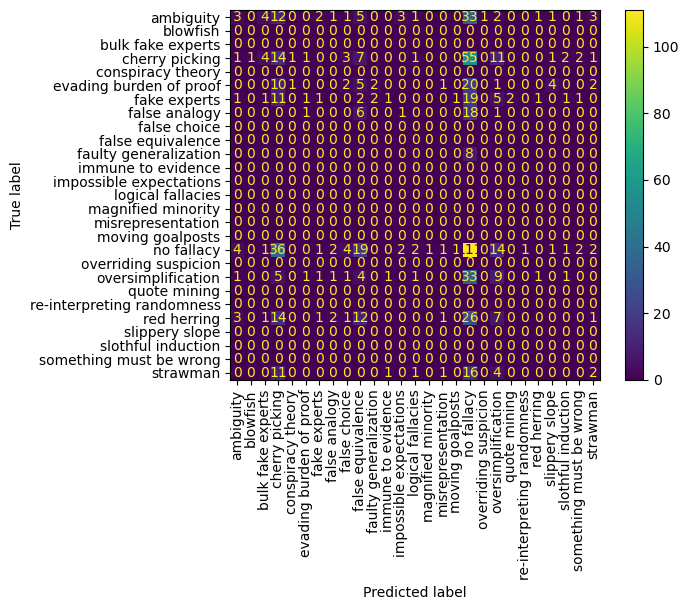

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_true_all, y_pred_all, target_names=le.classes_, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_true_all, y_pred_all,display_labels=le.classes_, xticks_rotation='vertical')

                            precision    recall  f1-score   support

                 ambiguity       0.23      0.05      0.08        63
                  blowfish       0.00      0.00      0.00         0
         bulk fake experts       0.00      0.00      0.00         0
            cherry picking       0.12      0.16      0.14        87
         conspiracy theory       0.00      0.00      0.00         0
   evading burden of proof       0.00      0.00      0.00        39
              fake experts       0.17      0.02      0.04        44
             false analogy       0.00      0.00      0.00        22
              false choice       0.00      0.00      0.00         0
         false equivalence       0.00      0.00      0.00         0
     faulty generalization       0.00      0.00      0.00         5
        immune to evidence       0.00      0.00      0.00         0
   impossible expectations       0.00      0.00      0.00         0
         logical fallacies       0.00      0.00

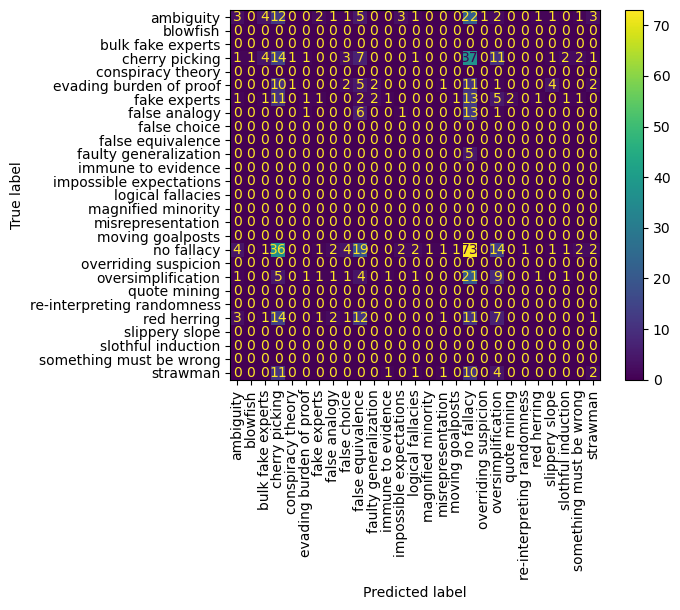

In [14]:
print(classification_report(y_true_ham, y_pred_ham, target_names=le.classes_, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_true_ham, y_pred_ham,display_labels=le.classes_, xticks_rotation='vertical')

                         precision    recall  f1-score   support

              ambiguity       0.33      0.05      0.08        63
               blowfish       0.00      0.00      0.00         0
      bulk fake experts       0.00      0.00      0.00         0
         cherry picking       0.18      0.16      0.17        87
      conspiracy theory       0.00      0.00      0.00         0
evading burden of proof       0.00      0.00      0.00        39
           fake experts       0.20      0.02      0.04        44
          false analogy       0.00      0.00      0.00        22
           false choice       0.00      0.00      0.00         0
      false equivalence       0.00      0.00      0.00         0
  faulty generalization       0.00      0.00      0.00         5
     immune to evidence       0.00      0.00      0.00         0
impossible expectations       0.00      0.00      0.00         0
      logical fallacies       0.00      0.00      0.00         0
      misrepresentation 

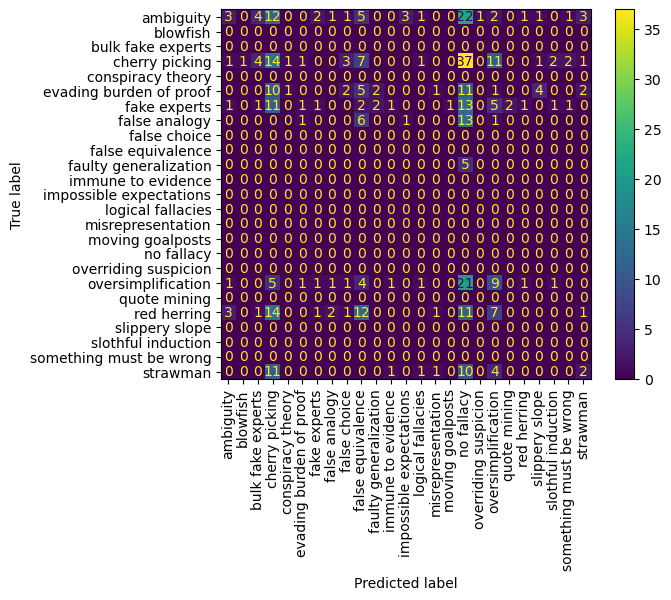

In [23]:
# labels for only correct format & excluding no fallacy
le = preprocessing.LabelEncoder()
le.fit(list(set(df[(df['label'] != 'no fallacy') & (df['dict'] == True)]['label'].to_list() + df[(df['label'] != 'no fallacy')& (df['dict'] == True)]['predictions'].to_list())))


y_true_fallacy = le.transform(df[(df['label'] != 'no fallacy') & (df['dict'] == True)]['label'].to_numpy())
y_pred_fallacy = le.transform(df[(df['label'] != 'no fallacy') & (df['dict'] == True)]['predictions'].to_numpy())

print(classification_report(y_true_fallacy, y_pred_fallacy, target_names=le.classes_, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_true_fallacy, y_pred_fallacy,display_labels=le.classes_, xticks_rotation='vertical')